In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
data16 = pd.read_excel('./Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xls')
data16

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
0,63391,1568.4050,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,68358,1942.1870,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,73589,1246.5380,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,71106,1445.2610,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,80087,1251.5240,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,85983,1157.1160,444.3447,248.8627,0.8284,330.8730,0.9823,87536,0.6799,1.7855,0.8070,0.7446,0.0052,0.0029,0.5545,0.9900,Siit_Pistachio
2144,85691,2327.3459,439.8794,278.9297,0.7732,330.3107,0.8886,96439,0.6590,1.5770,0.1988,0.7509,0.0051,0.0033,0.5639,0.8892,Siit_Pistachio
2145,101136,1255.6190,475.2161,271.3299,0.8210,358.8459,0.9888,102286,0.7584,1.7514,0.8061,0.7551,0.0047,0.0027,0.5702,0.9987,Siit_Pistachio
2146,97409,1195.2150,452.1823,274.5764,0.7945,352.1718,0.9902,98376,0.7635,1.6468,0.8569,0.7788,0.0046,0.0028,0.6066,0.9989,Siit_Pistachio


In [4]:
data16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           2148 non-null   int64  
 1   PERIMETER      2148 non-null   float64
 2   MAJOR_AXIS     2148 non-null   float64
 3   MINOR_AXIS     2148 non-null   float64
 4   ECCENTRICITY   2148 non-null   float64
 5   EQDIASQ        2148 non-null   float64
 6   SOLIDITY       2148 non-null   float64
 7   CONVEX_AREA    2148 non-null   int64  
 8   EXTENT         2148 non-null   float64
 9   ASPECT_RATIO   2148 non-null   float64
 10  ROUNDNESS      2148 non-null   float64
 11  COMPACTNESS    2148 non-null   float64
 12  SHAPEFACTOR_1  2148 non-null   float64
 13  SHAPEFACTOR_2  2148 non-null   float64
 14  SHAPEFACTOR_3  2148 non-null   float64
 15  SHAPEFACTOR_4  2148 non-null   float64
 16  Class          2148 non-null   object 
dtypes: float64(14), int64(2), object(1)
memory usage: 28

In [5]:
for column in data16.columns[:-1]:
    print(column, ":", data16[column].std())

AREA : 13121.73779890054
PERIMETER : 375.56550345439894
MAJOR_AXIS : 32.445303508178796
MINOR_AXIS : 30.310695396739984
ECCENTRICITY : 0.048758957264750165
EQDIASQ : 26.90860002379475
SOLIDITY : 0.05045218484942025
CONVEX_AREA : 13154.91932656929
EXTENT : 0.05253229423461956
ASPECT_RATIO : 0.24010025581296487
ROUNDNESS : 0.21275974294227137
COMPACTNESS : 0.04454714349125852
SHAPEFACTOR_1 : 0.000817253003312335
SHAPEFACTOR_2 : 0.00033976902710538436
SHAPEFACTOR_3 : 0.06394198264088032
SHAPEFACTOR_4 : 0.051840480731986036


In [6]:
data16['Class'].value_counts()

Kirmizi_Pistachio    1232
Siit_Pistachio        916
Name: Class, dtype: int64

In [7]:
labels = ['Kirmizi_Pistachio', 'Siirt_Pistachio']
one_hot_encode = lambda x: 0 if x == 'Kirmizi_Pistachio' else 1
one_hot_encode_revert = lambda x: labels[x]

In [8]:
X = data16.drop('Class', axis=1)
y = data16['Class']
y = y.apply(one_hot_encode)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

In [9]:
scaler = MinMaxScaler()
pca = PCA()
knn = KNeighborsClassifier()
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])

In [10]:
count_sqrt = math.floor(np.sqrt(X.shape[0]))
print('dataset sample count: %i' % X.shape[0])
print('square root: %i' % count_sqrt)

dataset sample count: 2148
square root: 46


## Grid Search

In [11]:
params = {
    'pca__n_components': [3, 5, 7, 9, 11, 13, 15, X.shape[1]],
    'knn__n_neighbors': np.arange(3, count_sqrt + 1, 2),
    'knn__metric': ['euclidean', 'minkowski', 'manhattan'],
    # 'knn__metric': ['euclidean', 'minkowski', 'manhattan', 'mahalanobis']
}

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

grid = GridSearchCV(pipe, params, cv=10, scoring=scoring, refit='accuracy', return_train_score=False, verbose=1)
grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'minkowski', 'manhattan'],
                         'knn__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45]),
                         'pca__n_components': [3, 5, 7, 9, 11, 13, 15, 16]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [12]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 528 candidates, totalling 5280 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'minkowski', 'manhattan'],
                         'knn__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45]),
                         'pca__n_components': [3, 5, 7, 9, 11, 13, 15, 16]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [13]:
grid.best_params_

{'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'pca__n_components': 5}

In [14]:
print("---- GridSearchCV set stats:")
for label, amount in zip(labels, np.bincount(y_train)):
    print("%s: %i datapoints" % (label, amount))

---- GridSearchCV set stats:
Kirmizi_Pistachio: 985 datapoints
Siirt_Pistachio: 733 datapoints


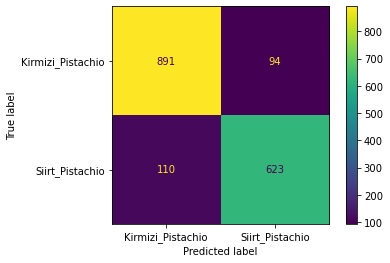

In [15]:
plot_confusion_matrix(grid, X_train, y_train, display_labels=labels)  
plt.show()

## Test

In [16]:
print("---- test set stats:")
for label, amount in zip(labels, np.bincount(y_test)):
    print("%s: %i datapoints" % (label, amount))

---- test set stats:
Kirmizi_Pistachio: 247 datapoints
Siirt_Pistachio: 183 datapoints


---- 16-feature dataset test results
Grid Search CV (10 folds) + PCA found the following hyperparameters:
knn__metric: euclidean
knn__n_neighbors: 11
pca__n_components: 5


---- test metrics:
   accuracy  f1_score  precision    recall
0  0.872093  0.845938   0.867816  0.825137


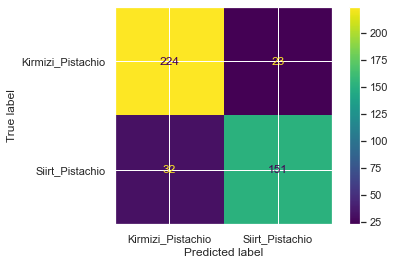

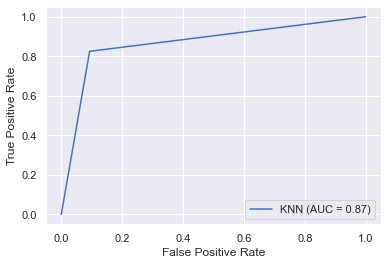

In [20]:
y_pred = grid.predict(X_test)

test_metrics = pd.DataFrame({
    "accuracy": [accuracy_score(y_test, y_pred)],
    "f1_score": [f1_score(y_test, y_pred)],
    "precision": [precision_score(y_test, y_pred)],
    "recall": [recall_score(y_test, y_pred)],
})

print("---- 16-feature dataset test results")
print("Grid Search CV (10 folds) + PCA found the following hyperparameters:")
print("\n".join(["%s: %s" % (param, value) for param, value in grid.best_params_.items()]))
print("\n")
print("---- test metrics:")
print(test_metrics)

cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot()
plt.show()

sns.set_theme()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='KNN')
display.plot()
plt.show()

In [32]:
pd.DataFrame(cm).to_csv("confusion_matrix_16_features.csv")
pd.DataFrame([fpr, tpr, [roc_auc for x in range(len(fpr))]]).to_csv("roc_curve_16_features.csv")